In [1]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.io import wavfile
from scipy.linalg import solve_toeplitz

## Definição do problema

In [2]:
num_realizacoes = 500 # Número de repetições de cada experimento a fazer
max_samples = 6000 # Coloque None para usar o vetor inteiro

#### Leitura da resposta ao impulso da garrafa

In [3]:
f, garrafa = wavfile.read(filename="Garrafa.wav")
garrafa = garrafa[:max_samples]
M = garrafa.shape[0]

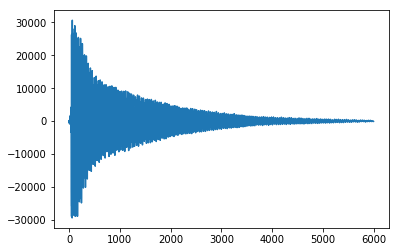

In [4]:
plt.plot(garrafa)

#### Definição do ruído de leitura

In [5]:
var_ruido_leitura = 0.01
std_ruido_leitura = np.sqrt(var_ruido_leitura)
ruido_leitura = np.random.normal(0, std_ruido_leitura, garrafa.shape)

####  Definição do ruído de excitação

In [6]:
ruido_excitacao = np.random.normal(0, 1, garrafa.shape)

#### A resposta ao ruído de excitação

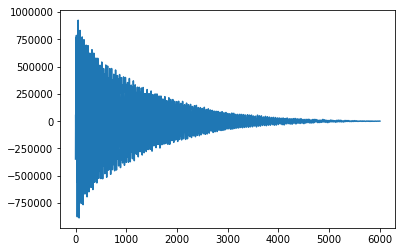

In [7]:
resposta = np.convolve(ruido_excitacao, garrafa)[M-1:] + ruido_leitura
plt.plot(resposta[:6000])

In [8]:
def erro(resposta, estimado):
    assert resposta.shape == estimado.shape, "Os dois vetores precisam ter o mesmo tamanho."
    
    vetor_erro_bruto = np.square(resposta - estimado)
    erro_bruto = vetor_erro_bruto.sum()
    
    vetor_normalizacao = np.square(resposta)
    normalizacao = vetor_normalizacao.sum()
    
    return erro_bruto / normalizacao

## 2. Estimador por Correlação
$$ \rho[k] = \frac{1}{K} \sum_{m=0}^{K} r[m]w[k-m] \approx \frac{h[k]}{K} 
\Rightarrow \sum_{m=0}^{K} r[m]w[k-m] \approx h[k]$$

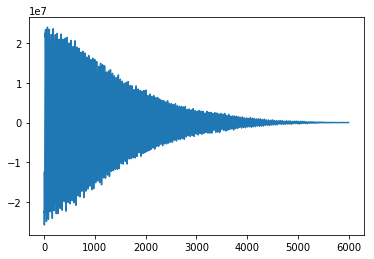

In [9]:
estimativa_correlacao = np.correlate(resposta, ruido_excitacao, mode='full')
plt.plot(estimativa_correlacao[M-1:])

In [10]:
erro_correlacao = erro(garrafa, estimativa_correlacao[M-1:])

## 3. Estimador com média de correlação

In [11]:
def experimento_com_repeticoes(experimento, num_realizacoes, resp_impulso, std_ruido):
    estimativa = 0
    for i in range(num_realizacoes):
        pho = experimento(resp_impulso, std_ruido)
        estimativa = estimativa + pho[-resp_impulso.shape[0]:]

    return estimativa / num_realizacoes # Média entre realizações para cada posição

In [12]:
def estimativa_correlacao(resp_impulso, std_ruido):
    ruido_leitura = np.random.normal(0, std_ruido, resp_impulso.shape)
    ruido_excitacao = np.random.normal(0, 1, resp_impulso.shape)
    resultado = np.convolve(ruido_excitacao, resp_impulso)[-resp_impulso.shape[0]:] + ruido_leitura
    
    estimativa = np.correlate(resultado, ruido_excitacao, 'full')
    return estimativa

In [13]:
estimativa_pela_media = experimento_com_repeticoes(estimativa_correlacao, num_realizacoes, garrafa, std_ruido_leitura)

In [14]:
erro_media = erro(garrafa, estimativa_pela_media)

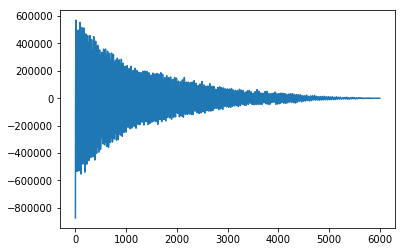

In [15]:
plt.plot(estimativa_pela_media)

In [16]:
erro_media / erro_correlacao

0.0003296913203319659

## 4. Mínimo Erro Quadrático Médio

In [17]:
ruido_leitura = np.random.normal(0, std_ruido_leitura, garrafa.shape)
ruido_excitacao = np.random.normal(0, 1, garrafa.shape)
resposta = np.convolve(ruido_excitacao, garrafa)[M-1:] + ruido_leitura

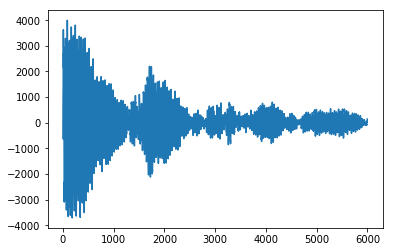

In [18]:
auto_corr = np.correlate(ruido_excitacao, ruido_excitacao, mode='full')[M-1:]
plt.plot(solve_toeplitz(auto_corr, np.correlate(resposta, ruido_excitacao, 'full')[M-1:]))

In [19]:
def estimativa_toeplitz(resposta_impulso, std_ruido):
    ruido_leitura = np.random.normal(0, std_ruido_leitura, resposta_impulso.shape)
    ruido_excitacao = np.random.normal(0, 1, resposta_impulso.shape)
    resposta = np.convolve(ruido_excitacao, resposta_impulso)[-resposta_impulso.shape[0]:] + ruido_leitura
    
    auto_corr = np.correlate(ruido_excitacao, ruido_excitacao, 'full')[-resposta_impulso.shape[0]:]
    corr_resposta_ruido = np.correlate(resposta, ruido_excitacao, 'full')[-resposta_impulso.shape[0]:]
    return solve_toeplitz(auto_corr, corr_resposta_ruido)

In [20]:
estimativa_por_mse = experimento_com_repeticoes(estimativa_toeplitz, num_realizacoes, garrafa, std_ruido_leitura)

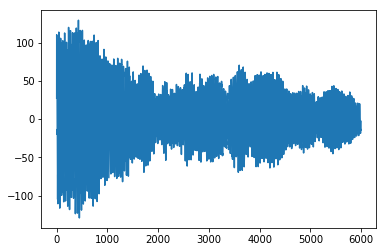

In [21]:
plt.plot(estimativa_por_mse)

In [22]:
erro_toeplitz = erro(garrafa, estimativa_por_mse)

In [23]:
erro_toeplitz / erro_media

0.0015019110500084497

In [24]:
erro_toeplitz / erro_correlacao

4.95167037098455e-07